# Data Science 1 - Signal analysis

## Lesson 5 - Applications of the Fourier transform

&copy; 2021, dr.ir. Dave R.M. Langers (LADR, ZP11/H1.90, [d.r.m.langers@pl.hanze.nl](mailto:d.r.m.langers@pl.hanze.nl))

<img src="https://bioinf.nl/~davelangers/dave.png" width="10%" height="10%" alt="Dave Langers" /> 

<small>**Note:** step forward using `SPACE` or backward using `SHIFT`+`SPACE`, or use the arrows in the bottom right to navigate; run code cells using `CTRL`+`ENTER`.</small>

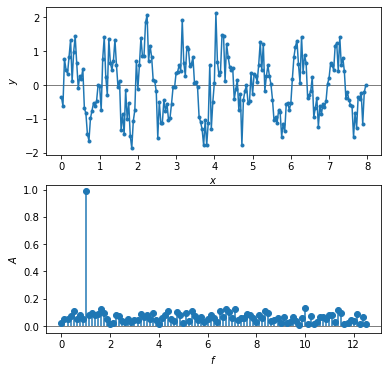

In [1]:
# Initialization

%matplotlib inline
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from IPython import display
from lesson5 import figure

### Main material

*Hands-on Signal Analysis with Python: An Introduction*, **chapter 9.1, 9.3.1-2, 9.4, 9.7**

<img src="https://images-na.ssl-images-amazon.com/images/I/41CaMa-FgDS._SX375_BO1,204,203,200_.jpg" width="5%" height="5%" alt="Hands-on Signal Analysis with Python: An Introduction" />

### <a id="/1">Lesson 5 - Applications of the Fourier transform</a>

* <u>Part 5A</u><br />*Fourier filtering*

* <span style="color:#336699"><a href="#/7">Part 5B</a><br />Fourier interpolation</span>

* <span style="color:#336699"><a href="#/13">Part 5C</a><br />Fourier smoothing</span>

* <span style="color:#336699"><a href="#/19">Part 5D</a><br />Short-term Fourier Transform</span>

### Inverse Fourier transform

Some operations are most easily carried out in the [time domain](https://en.wikipedia.org/wiki/Time_domain). For example:

* extending a signal by zero-padding, or by repeating it multiple times

* cutting away localized [artifacts](https://en.wikipedia.org/wiki/Artifact_(error)), like spikes

* multiplying a signal with a window

* determining minima or maxima

However, other operations prove to be simpler in the [frequency domain](https://en.wikipedia.org/wiki/Frequency_domain). For example:

* interpolation of intermediate values

* removing periodic [artifacts](https://en.wikipedia.org/wiki/Artifact_(error)), like 50-Hz power line interference

* smoothing to remove signal noise, or other types of filtering

* determining the frequency of a quasi-periodic signal

For this reason, it is convenient to be able to transform a signal from the time domain into the frequency domain, and to transform a spectrum from the frequency domain back into the time domain.

### Filtering

A [filter](https://en.wikipedia.org/wiki/Filter_(signal_processing)) consists of a function that removes unwanted features from a signal.

Many filters act in the frequency domain and are characterized by their [frequency response](https://en.wikipedia.org/wiki/Frequency_response). They can be seen as a multiplication of the spectrum by a [transfer function](https://en.wikipedia.org/wiki/Transfer_function). That is, the amplitude of every frequency component is multiplied by some frequency-dependent value $T(f)$.

$$
A'(f) = T(f) \cdot A(f)
$$

As a rule of thumb:

* for frequencies that are relevant, set $T(f)$ = 1

* for frequencies that are unwanted, set $T(f)$ = 0

Common types of filters let through certain frequency ranges and block others.

* A [low-pass filter](https://en.wikipedia.org/wiki/Low-pass_filter) has $T(f)=1$ for $f<f_\text{max}$, and $T(f)=0$ otherwise.<br />
  This filter can for instance be used to let through a coherently varying signal, while blocking most noise at high frequencies.
  
* A [high-pass filter](https://en.wikipedia.org/wiki/High-pass_filter) filter has $T(f)=1$ for $f>f_\text{min}$, and $T(f)=0$ otherwise.<br />
  This filter can for instance be used to let through fluctuating signals, while blocking slow drift.
  
[Band-pass filters](https://en.wikipedia.org/wiki/Band-pass_filter) and [band-stop filters](https://en.wikipedia.org/wiki/Band-stop_filter) combine these ideas, by letting through or blocking frequencies in an interval $f_\text{min}<f<f_\text{max}$, respectively.

The figure illustrates an artificial signal that consists of a sinusoid with frequency $f=1$, plus some random noise.

The spectrum shows a strong peak at $f=1$, and weaker but non-zero amplitudes at all other frequencies.

We wish to "clean up" the signal and remove the noise, whilst still retaining the sinusoidal signal. This is not trivial to achieve in the time domain, but it is easy in the frequency domain.

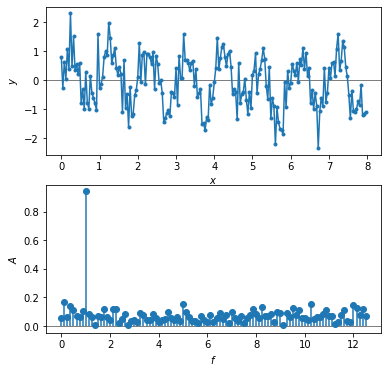

Figure 1: Signal & Spectrum


In [2]:
figure(1)

Because we know that we are interested in oscillations at $f=1$, we define a transfer function $T(f)$ that equals 1 for $f=1$, and 0 otherwise.

When we multiply the frequency spectrum by this transfer function, only the peak "survives".

Transform the spectrum back into the time domain, we obtain a clean signal that matches the original signal not only in frequency, but also in phase and amplitude.

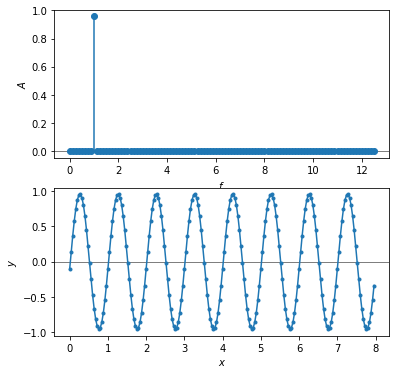

Figure 2: Spectrum & Signal


In [3]:
figure(2)

### Example

Consider the following data regarding the average temperature in the city of Groningen across all months in a year (from: [Climates to travel](https://www.climatestotravel.com/climate/netherlands/groningen)).

| Month     | T [°C] |   | Month     | T [°C] |
| --------- | ------ | - | --------- | ------ |
| January   |  2.5   |   | July      | 17.5   |
| February  |  2.9   |   | August    | 17.2   |
| March     |  5.5   |   | September | 14.2   |
| April     |  8.9   |   | October   | 10.2   |
| May       | 12.4   |   | November  |  6.1   |
| June      | 15.1   |   | December  |  3.3   |

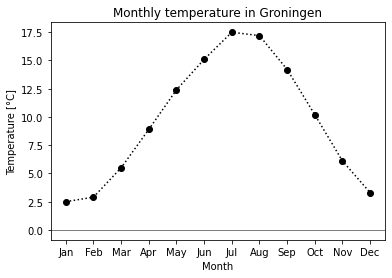

In [2]:
from calendar import month_abbr
months = [month_abbr[i + 1] for i in range(12)]
temps = np.array([2.5,  2.9,  5.5,  8.9,  12.4, 15.1,
                  17.5, 17.2, 14.2, 10.2, 6.1,  3.3])

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(temps, 'o:k')
plt.xlabel('Month'); plt.ylabel('Temperature [°C]')
plt.title('Monthly temperature in Groningen')
plt.xticks(range(12), months)
plt.show()

We can transform these data into a spectrum using the code from the previous lesson.

The first two frequency components can be interpreted meaningfully; the other much weaker components may be attributed to random effects.

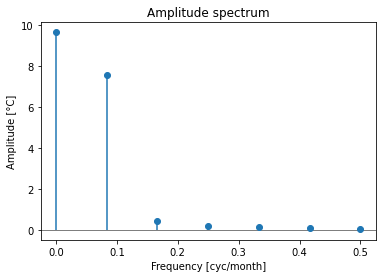

In [5]:
coef = np.fft.rfft(temps, norm='forward')
coef[1:-1] = 2.0 * np.conj(coef[1:-1])
a, b = np.real(coef), np.imag(coef)
spectrum = np.sqrt(a * a + b * b)
f = np.fft.rfftfreq(temps.size, 1.0)

plt.axhline(0.0, color='k', lw=0.5)
plt.stem(f, spectrum, basefmt='None')
plt.xlabel('Frequency [cyc/month]'); plt.ylabel('Amplitude [°C]')
plt.title('Amplitude spectrum')
plt.show()

Suppose we wish to remove the contribution of the higher frequency components. In the frequency domain, we can define a transfer function that achieves this.

We filter the original signal using a low-pass filter that only lets through the frequencies below a certain cut-off, here e.g. $f_\text{max} \approx 0.1$ cyc/month.

The transfer function is applied to both the cosine and sine coefficients $a$ and $b$.

<small>**Note:** we could also write `a *= (f < 0.1); b *= (f < 0.1)`.</small>

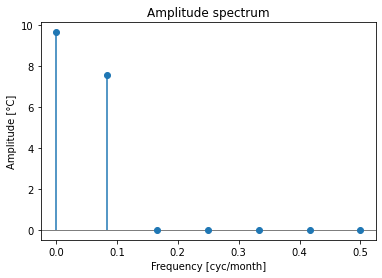

In [6]:
transfer = np.array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
a *= transfer
b *= transfer
spectrum = np.sqrt(a * a + b * b)

plt.axhline(0.0, color='k', lw=0.5)
plt.stem(f, spectrum, basefmt='None')
plt.xlabel('Frequency [cyc/month]'); plt.ylabel('Amplitude [°C]')
plt.title('Amplitude spectrum')
plt.show()

We can subsequently use the *inverse* (real-valued, fast) Fourier transform `irfft()` from the `numpy.fft` module to reconstruct the original signal.

Because the number of components in the spectrum is approximately half as small as the number of samples in the signal, there is ambiguity in the size of the signal that needs to be reconstructed. Be aware that `irfft()` by default assumes the required number of samples $n$ is even; if it is odd, it needs to be specified as an extra argument `irfft(coef, n)`.

In [7]:
help(np.fft.irfft)

Help on function irfft in module numpy.fft:

irfft(a, n=None, axis=-1, norm=None)
    Computes the inverse of `rfft`.
    
    This function computes the inverse of the one-dimensional *n*-point
    discrete Fourier Transform of real input computed by `rfft`.
    In other words, ``irfft(rfft(a), len(a)) == a`` to within numerical
    accuracy. (See Notes below for why ``len(a)`` is necessary here.)
    
    The input is expected to be in the form returned by `rfft`, i.e. the
    real zero-frequency term followed by the complex positive frequency terms
    in order of increasing frequency.  Since the discrete Fourier Transform of
    real input is Hermitian-symmetric, the negative frequency terms are taken
    to be the complex conjugates of the corresponding positive frequency terms.
    
    Parameters
    ----------
    a : array_like
        The input array.
    n : int, optional
        Length of the transformed axis of the output.
        For `n` output points, ``n//2+1`` input po

However, before we can use the inverse Fourier transform, we need to combine `a` and `b` back into a single complex spectrum.

In [8]:
coef = a + 1j * b

Moreover, we need to "undo" the multiplication by a factor 2 of all frequencies except the zero and Nyquist frequency, and the flip of the imaginary component.

In [9]:
coef[1:-1] = np.conj(coef[1:-1]) / 2.0

Now we can invert the Fourier transform.

Since we used the `norm='forward'` argument when determining the Fourier transform, this needs to be specified to the `irfft()` function as well.

<small>**Note:** for this example, the result is a pure sinusoid, equivalent to applying the `trig_curvefit()` function from the previous lesson.</small>

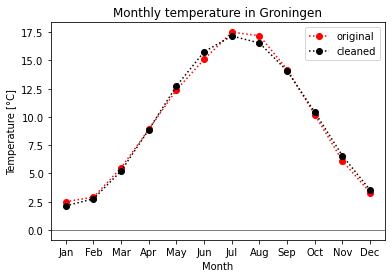

In [10]:
cleaned = np.fft.irfft(coef, norm='forward')

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(temps, 'o:r', label='original')
plt.plot(cleaned, 'o:k', label='cleaned')
plt.xlabel('Month'); plt.ylabel('Temperature [°C]')
plt.title('Monthly temperature in Groningen')
plt.legend(); plt.xticks(range(12), months)
plt.show()

### Other useful functions

The `scipy.fft` module contains an `irfft()` function that operates identically to that from `numpy`, but provides a couple of additional options. We will not make use of these, so for our purposes these functions are equivalent.

Similarly, `scipy.fft` supplies the `idct()` function that inverts the discrete cosine transform that we considered in lesson 4, part D. Like the `dct()` function, it allows the `type=1` parameter to be passed.</small>

### Exercise 1

Generate an artificial 4-second signal that contains a square wave of frequency $f=1$ Hz, sampled with a sampling frequency of 50 Hz. Apply a low-pass filter and vary the cutoff $f_\text{max}$. What does the resulting signal look like in the time domain?

In [5]:
def square(t):
    return np.sign(np.sin(2*np.pi*f*(t + 0.25)))

def low_pass_filter(a, f, fmax):
    return a  * (f < fmax)

In [6]:
L = 4
f = 1
fs = 50 # 1 / ts 
n = L * fs
ts = L / n

In [7]:
x = np.linspace(0, 4, 200, endpoint=False)
y = square(x)

200
200
200


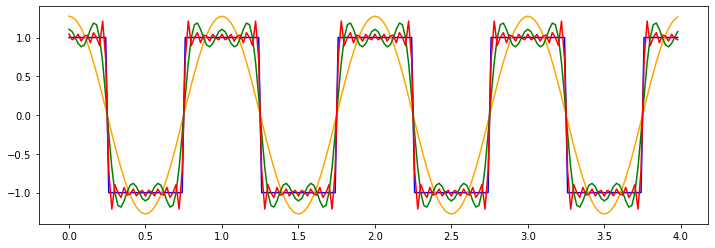

In [24]:
plt.figure(figsize=(12, 4))

plt.plot(x, y, color='blue')

colors = ['orange', 'green', 'red']

for i, fmax in enumerate([2, 6, 18]):
    # 1) convert to frequency domain
    print(y.size)
    coef = np.fft.rfft(y, norm='forward')
    coef[1:-1] = 2.0 * np.conj(coef[1:-1])
    a, b = np.real(coef), np.imag(coef)
    spectrum = np.sqrt(a*a + b*b)
    f = np.fft.rfftfreq(y.size, ts)

    # 2) filtering
    a *= (f < fmax)
    b *= (f < fmax)

    # 3) Reconstruct (from frequency to time domain)
    spectrum = np.sqrt(a*a + b*b)
    coef = a + 1j * b
    coef[1:-1] = np.conj(coef[1:-1]) / 2
    cleaned = np.fft.irfft(coef, norm='forward')

    plt.plot(x, cleaned, color=colors[i])

plt.show()

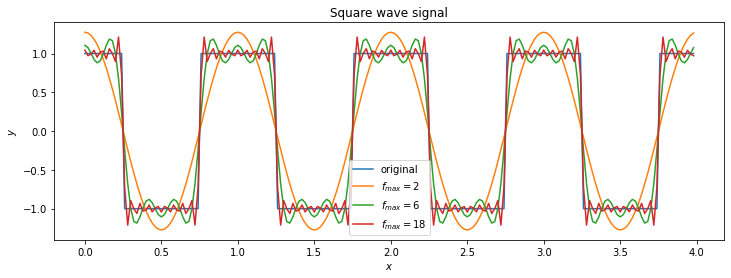

### Exercise 2

The below code fragment loads the respiratory volume of a subject while standing breathing normally (first half minute) or breathing deeply (second half minute) according to a sensor placed around the thorax (from: [biosignalsplux](https://biosignalsplux.com/learn/samples.html)).

```python
url = 'http://biosignalsplux.com/downloads/samples/respiration-rip/SampleRIP_converted.txt'
respiration = pd.read_csv(url, sep='\t', dtype=float, comment='#',
              usecols=[0, 2], names=['Time [s]', 'Volume [L]']).loc[::100, :]
respiration['Time [s]'] = respiration['Time [s]'] * 1e-3
```

Filter this signal using a band-pass filter with cutoff frequencies $f_\text{min}=10$ cyc/min and $f_\text{max}=20$ cyc/min.

In [25]:
url = 'http://biosignalsplux.com/downloads/samples/respiration-rip/SampleRIP_converted.txt'
respiration = pd.read_csv(url, sep='\t', dtype=float, comment='#',
              usecols=[0, 2], names=['Time [s]', 'Volume [L]']).loc[::100, :]
respiration['Time [s]'] = respiration['Time [s]'] * 1e-3
respiration.head()

Time [s]  Volume [L]
0         0.0     1.55237
100       0.1     1.54079
200       0.2     1.52344
300       0.3     1.51135
400       0.4     1.50476

In [37]:
x, y = respiration['Time [s]'], respiration['Volume [L]']

L = 1
n = x.size
ts = L / n

print(y.size)
# convert to frequency domain
coef = np.fft.rfft(y, norm='forward')
coef[1:-1] = 2.0 * np.conj(coef[1:-1])
a, b = np.real(coef), np.imag(coef)
spectrum = np.sqrt(a*a + b*b)
f = np.fft.rfftfreq(y.size, ts)

600


<StemContainer object of 3 artists>

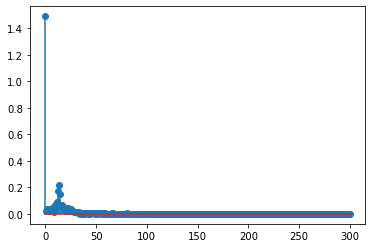

In [38]:
plt.stem(f, spectrum)

In [39]:
# filtering
fmin = 10
fmax = 20

a *= (f > fmin) & (f < fmax)
b *= (f > fmin) & (f < fmax)


# reconstruct signal
spectrum = np.sqrt(a*a + b*b)
coef = a + 1j * b
coef[1:-1] = np.conj(coef[1:-1]) / 2
cleaned = np.fft.irfft(coef, norm='forward')

Text(0.5, 0, 'Time [s]')

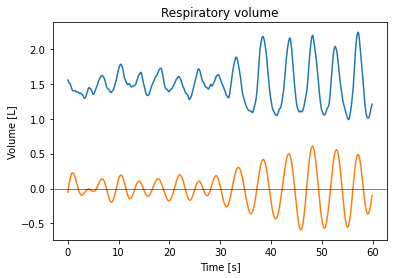

In [40]:

plt.plot(x, y, label='original')
plt.plot(x, cleaned, label='filtered')
plt.axhline(0.0, color='black', lw=0.5)

plt.title('Respiratory volume')
plt.ylabel('Volume [L]')
plt.xlabel('Time [s]')

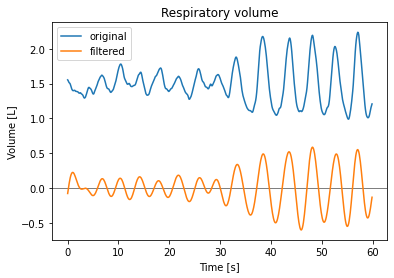

### Exercise 3

The following code downloads an electrocardiographic (ECG) signal that was recorded at a sampling rate of 500 Hz in a [telehealth environment](https://en.wikipedia.org/wiki/Telehealth) from two electrodes held in the left and right hand (from: [Khamis et al., Harvard dataverse](https://doi.org/10.7910/DVN/QTG0EP)).

```python
import io, requests
url = 'https://dataverse.harvard.edu/api/access/datafile/:' + \
      'persistentId?persistentId=doi:10.7910/DVN/QTG0EP/IW7ADN'
ecg = pd.read_csv(io.StringIO(requests.get(url).text),
                  usecols=[0], names=['Potential [mV]'])
```

Upon close visual inspection of the signal and its spectrum, the data can be seen to contain oscillations related to the heart beat, but also slow baseline drift (especially in the first half of the measurement) and a substantial artifact at 50 Hz caused by interference from [mains power](https://en.wikipedia.org/wiki/Utility_frequency).

Inspect the signal spectrum to design and apply a filter with a transfer function that removes the 50-Hz artifact as well as the drifting baseline.

In [41]:
import io, requests
url = 'https://dataverse.harvard.edu/api/access/datafile/:' + \
      'persistentId?persistentId=doi:10.7910/DVN/QTG0EP/IW7ADN'
ecg = pd.read_csv(io.StringIO(requests.get(url).text),
                  usecols=[0], names=['Potential [mV]'])

ecg.head()

Potential [mV]
0       -0.130240
1       -0.092253
2        0.108533
3        0.379867
4        0.607787

In [54]:
fs = 500 # sampling frequency
n = ecg.index.size
L = n / fs
ts = 1 / fs

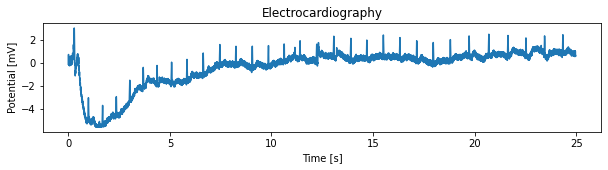

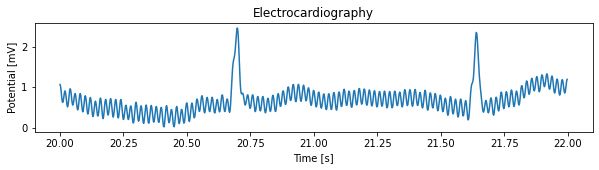

In [81]:
y = ecg['Potential [mV]']
x = ecg.index * ts

plt.figure(figsize=(10, 2))

plt.plot(x, y)
plt.title('Electrocardiography')
plt.ylabel('Potential [mV]')
plt.xlabel('Time [s]')
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(x[20*fs:22*fs], y[20*fs:22*fs])
plt.title('Electrocardiography')
plt.ylabel('Potential [mV]')
plt.xlabel('Time [s]')
plt.show()

(49.75, 50.25)

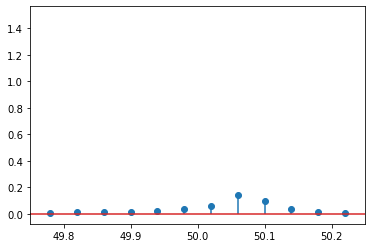

In [115]:
# Corresponding frequency domain
# n = odd
coef = np.fft.rfft(y, norm='forward')
coef[1:] = 2.0 * np.conj(coef[1:])
a, b = np.real(coef), np.imag(coef)
spectrum = np.sqrt(a*a + b*b)
f = np.fft.rfftfreq(y.size, ts)

plt.stem(f, spectrum)
plt.xlim([49.75, 50.25])

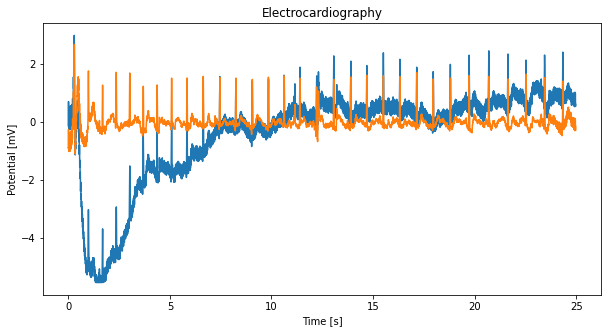

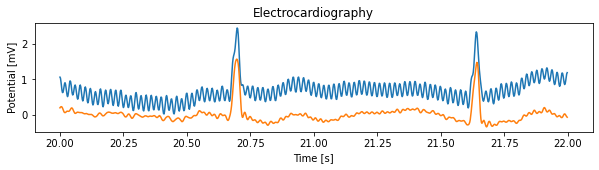

In [123]:
# Corresponding frequency domain
# n = odd
coef = np.fft.rfft(y, norm='forward')
coef[1:] = 2.0 * np.conj(coef[1:])
a, b = np.real(coef), np.imag(coef)
spectrum = np.sqrt(a*a + b*b)
f = np.fft.rfftfreq(y.size, ts)

# 2) filtering

# HOW DO I REMOVE 50Hz drift??
# band-stop filter
a *= (f < 49.9) | (f > 50.2)
b *= (f < 49.9) | (f > 50.2)

fmin = 1
a *= (f > fmin)
b *= (f > fmin)


# 3) Reconstruct (from frequency to time domain)
spectrum = np.sqrt(a*a + b*b)
coef = a + 1j * b
coef[1:] = np.conj(coef[1:]) / 2
cleaned = np.fft.irfft(coef, n=n, norm='forward')

plt.figure(figsize=(10, 5))

plt.plot(x, y)
plt.plot(x, cleaned)
plt.title('Electrocardiography')
plt.ylabel('Potential [mV]')
plt.xlabel('Time [s]')
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(x[20*fs:22*fs], y[20*fs:22*fs])
plt.plot(x[20*fs:22*fs], cleaned[20*fs:22*fs])
plt.title('Electrocardiography')
plt.ylabel('Potential [mV]')
plt.xlabel('Time [s]')
plt.show()

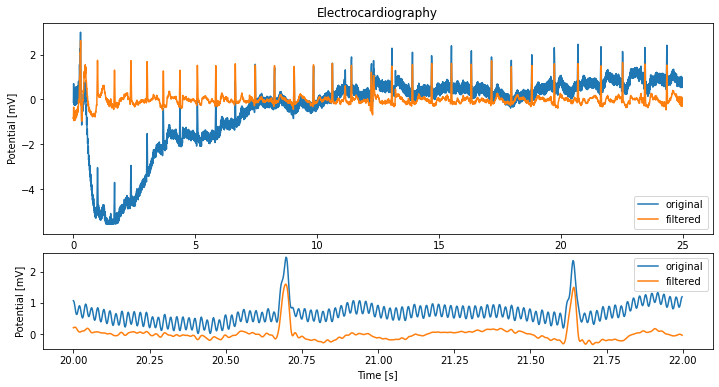

### Exercise 4

The following code loads information regarding the water level as measured at 10-minute intervals in Lauwersoog (Groningen, NL) over the past 4 weeks (from: [Rijkswaterstaat](https://rijkswaterstaatdata.nl)).

```python
url = 'https://waterinfo.rws.nl/api/Download/CSV?expertParameter=' + \
      'Waterhoogte%20Oppervlaktewater%20t.o.v.%20Normaal%20Amsterdams%20Peil%20in%20cm' + \
      '&locationSlug=Lauwersoog(LAUW)&timehorizon=-672,0'
tides = pd.read_csv(url, sep=';', header=0, usecols=[0, 1, 4],
                    names=['Date', 'Time', 'Water level [cm NAP]']).dropna()
```

Split this signal into two constituent parts, one containing all the frequencies up to 1.5 cycle per day, and another containing all the frequencies exceeding 1.5 cycle per day. Use the *discrete cosine transform* to achieve this.

What is your interpretation of the separate parts?

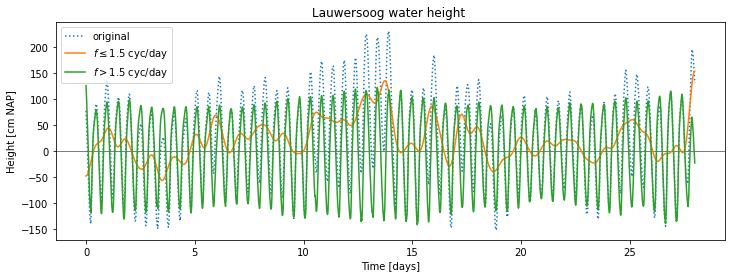

### Exercise 5

The following code loads the daily percentage sunshine that was measured across the last four years in Eelde (Groningen, NL).

```python
url = 'https://daggegevens.knmi.nl/klimatologie/daggegevens?' + \
      'start=20180101&end=20211231&stns[280]=1&vars[SP]=1'
sun = pd.read_csv(url, comment='#', usecols=[1, 2], names=['Day', 'Sunshine [%]'])
```

Filter this signal using a transfer function that is zero everywhere, except for frequencies that are an exact multiple of 1 cyc/yr, but not exceeding 5 cyc/yr. Decide for yourself whether the *discrete Fourier transform* or the *discrete cosine transform* is more natural to use here.

What is the effect of only letting through frequencies that do not exceed 5 cyc/yr? And what is the effect of only letting through frequencies that are multiples of 1 cyc/yr?

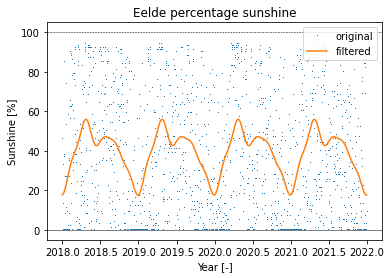

### <a id="/7">Lesson 5 - Applications of the Fourier transform</a>

* <span style="color:#336699"><a href="#/1">Part 5A</a><br />Fourier filtering</span>

* <u>Part 5B</u><br />*Fourier interpolation*

* <span style="color:#336699"><a href="#/13">Part 5C</a><br />Fourier smoothing</span>

* <span style="color:#336699"><a href="#/19">Part 5D</a><br />Short-term Fourier Transform</span>

### Time-frequency duality

In the previous lesson, we saw that the range of frequencies in a signal's spectrum, bounded by the [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency) $f_\text{Ny}$, is determined by the sampling resolution in time, i.e. the sampling time $t_s$.

$$
f_\text{Ny} = \frac{1}{2t_s}
$$

Therefore:

* A *denser* sampling corresponds with a more *extensive* spectrum

<small>**Note:** in the limit, a *continuous* signal corresponds with an *infinite* spectrum.</small>

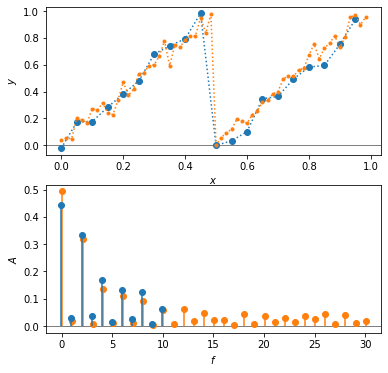

Figure 3: Signals & Spectra


In [16]:
figure(3)

The lowest non-zero frequency always corresponds with one cycle across the entire signal, i.e. $f_1=\frac{1}{L}$. Therefore, also the separation between neighboring frequency components equals $\Delta f=\frac{1}{L}$.

In other words, the duration of the signal $L$ is related to the frequency separation $\Delta f$ according to

$$
L = \frac{1}{\Delta f}
$$

Therefore:

* A more *extensive* sampling corresponds with a *denser* spectrum

<small>**Note:** in the limit, an *infinite* signal corresponds with a *continuous* spectrum.</small>

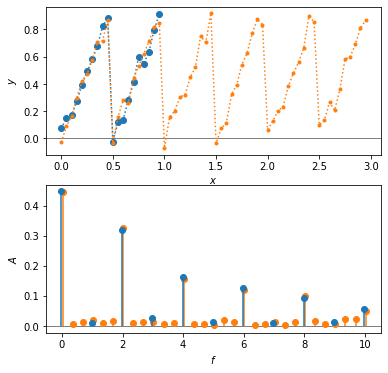

Figure 4: Signals & Spectra


In [17]:
figure(4)

In summary, there is a duality between the time and frequency domains:

* Temporal resolution relates to spectral extent

$$
t_s \cdot f_\text{Ny} = \frac{1}{2}
$$

* Spectral resolution relates to temporal extent

$$
\Delta f \cdot L = 1
$$

### Fourier interpolation

Interpolation consists of the estimation of signal values $y(x)$ at $x$ that are intermediate between measurements.

When working with equidistant samples, interpolation consists of increasing the temporal resolution of a signal. This is also known as [upsampling](https://en.wikipedia.org/wiki/Upsampling).

Given the time-frequency duality, this amounts to extending the frequency range of the spectrum.

Since no information is available about signal components above the Nyquist-frequency, the most natural approach is to pad the spectrum with zeros.

<small>**Note:** similarly, decreasing the sampling frequency is known as [downsampling](https://en.wikipedia.org/wiki/Downsampling), which can be achieved by entirely removing the highest frequency components from the signal's spectrum (as opposed to merely setting them equal to zero when low-pass filtering).</small>

The illustration shows that when the spectrum is extended with zeros, the signal in the time domain is interpolated.

If the upsampling is carried out by an integer factor, the original data should be reproduced exactly.

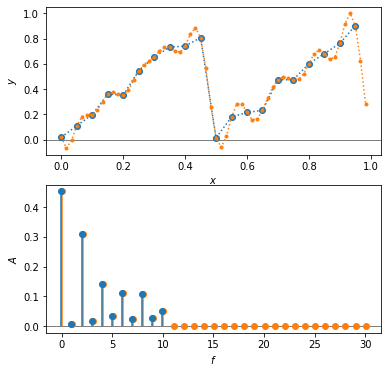

Figure 5: FFT interpolation


In [18]:
figure(5)

The same can be achieved with the type-I discrete cosine transform.

The result differs from the discrete Fourier transform in its assumptions about the boundary condition: Fourier transforms assume that a signal wraps around, whereas the cosine transform assumes the signal is extended by reflection.

<small>**Note:** some accurate bookkeeping is required if the signal needs to be upsampled by an integer factor without extrapolating beyond the boundary points.</small>

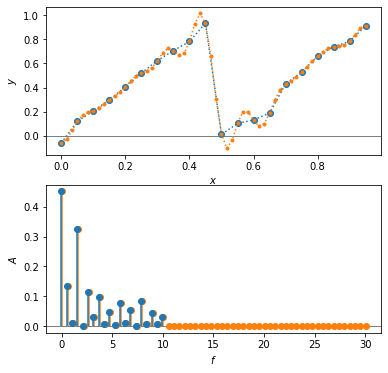

Figure 6: DCT interpolation


In [19]:
figure(6)

### Example

Again, consider the following data regarding the average temperature in the city of Groningen across all months in a year (from: [Climates to travel](https://www.climatestotravel.com/climate/netherlands/groningen)).

| Month     | T [°C] |   | Month     | T [°C] |
| --------- | ------ | - | --------- | ------ |
| January   |  2.5   |   | July      | 17.5   |
| February  |  2.9   |   | August    | 17.2   |
| March     |  5.5   |   | September | 14.2   |
| April     |  8.9   |   | October   | 10.2   |
| May       | 12.4   |   | November  |  6.1   |
| June      | 15.1   |   | December  |  3.3   |

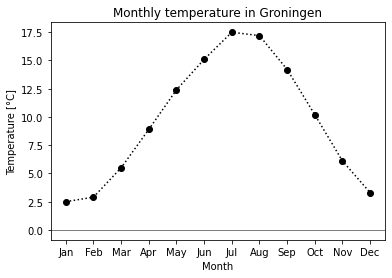

In [2]:
from calendar import month_abbr
months = [month_abbr[i + 1] for i in range(12)]
temps = np.array([2.5,  2.9,  5.5,  8.9,  12.4, 15.1,
                  17.5, 17.2, 14.2, 10.2, 6.1,  3.3])

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(temps, 'o:k')
plt.xlabel('Month'); plt.ylabel('Temperature [°C]')
plt.title('Monthly temperature in Groningen')
plt.xticks(range(12), months)
plt.show()

We wish to interpolate the signal, upsampling it by a factor four, thus obtaining approximately the weekly instead of monthly temperature.

First, we transform the signal into its spectrum again.

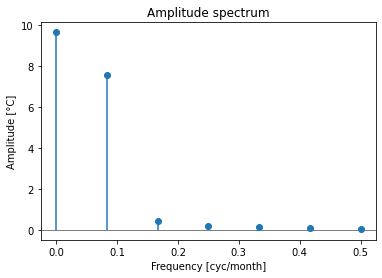

In [3]:
coef = np.fft.rfft(temps, norm='forward')
coef[1:-1] = 2.0 * np.conj(coef[1:-1])
a, b = np.real(coef), np.imag(coef)
spectrum = np.sqrt(a * a + b * b)
f = np.fft.rfftfreq(temps.size, 1.0)

plt.axhline(0.0, color='k', lw=0.5)
plt.stem(f, spectrum, basefmt='None')
plt.xlabel('Frequency [cyc/month]'); plt.ylabel('Amplitude [°C]')
plt.title('Amplitude spectrum')
plt.show()

The current Nyquist frequency equals $f_\text{Ny} = \frac{1}{2}$ cyc/month.

We wish to upsample to four times the temporal resolution, so the desired Nyquist frequency equals $f_\text{Ny} = 2$ cyc/month.

The separation between frequency components is $\frac{1}{L} = \frac{1}{12}$ cyc/month.

Therefore, we need to add

$$
\frac{2-\frac{1}{2}}{\frac{1}{12}} = 18
$$

additional frequency components.

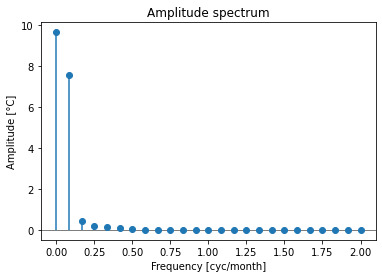

In [4]:
a = np.concatenate((a, np.zeros(18)))
b = np.concatenate((b, np.zeros(18)))
spectrum = np.sqrt(a * a + b * b)
f = np.fft.rfftfreq(4 * temps.size, 0.25)

plt.axhline(0.0, color='k', lw=0.5)
plt.stem(f, spectrum, basefmt='None')
plt.xlabel('Frequency [cyc/month]'); plt.ylabel('Amplitude [°C]')
plt.title('Amplitude spectrum')
plt.show()

We can subsequently use the `irfft()` function to reconstruct the corresponding signal.

<small>**Note:** although not strictly necessary here because the signal length is even, in the example the number of required samples is passed as an argument to the `irfft()` function.</small>

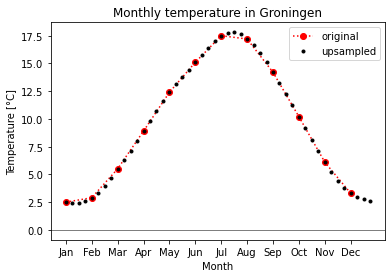

In [5]:
coef = a + 1j * b
coef[1:-1] = 0.5 * np.conj(coef[1:-1])
x = np.arange(48) / 4.0
y = np.fft.irfft(coef, 48, norm='forward')

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(temps, 'o:r', label='original')
plt.plot(x, y, '.k', label='upsampled')
plt.xlabel('Month'); plt.ylabel('Temperature [°C]')
plt.title('Monthly temperature in Groningen')
plt.legend(); plt.xticks(range(12), months)
plt.show()

### Other useful functions

The `scipy.signal` module contains a `resample()` function that performs resampling based on Fourier interpolation. As arguments, it requires the original data as well as the number of desired datapoints.

In [11]:
len(temps) / 48 * 1

0.25

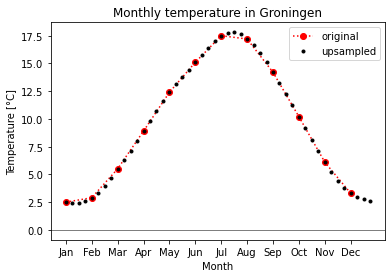

In [6]:
from scipy.signal import resample
y = resample(temps, 48) # how do they calculate everything based on yi and n??

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(temps, 'o:r', label='original')
plt.plot(x, y, '.k', label='upsampled')
plt.xlabel('Month'); plt.ylabel('Temperature [°C]')
plt.title('Monthly temperature in Groningen')
plt.legend(); plt.xticks(range(12), months)
plt.show()

### Exercise 6

Generate an artificial 4-second signal that contains a square wave of frequency $f=1$ Hz, sampled with a sampling frequency of 10 Hz.

Plot the signal, together with a signal that has been upsampled by a factor of five, and verify that the interpolated signal coincides with the original signal where those original samples are available.

In [186]:
L = 4
f = 1
fs = 10
n = L * fs
ts = L / n

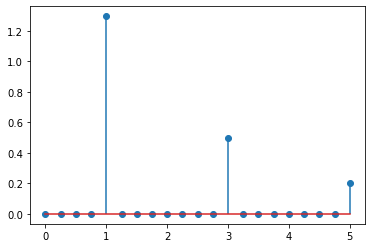

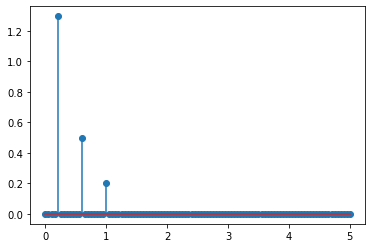

In [159]:
def square(t):
    return np.sign(np.sin(2*np.pi*f*(t + 0.25)))

x = np.linspace(0, L, n, endpoint=False)
y = square(x)

# Upsample signal by factor 5
# 1) From signal to frequency domain
# n is even
coef = np.fft.rfft(y, norm='forward')
coef[1:-1] = 2.0 * np.conj(coef[1:-1])
a, b = np.real(coef), np.imag(coef)
spectrum = np.sqrt(a*a + b*b)
freq = np.fft.rfftfreq(y.size, ts)

plt.stem(freq, spectrum)
plt.show()

## resample
fny = 1/(2*ts)
scalar = 5
fny_scaled = scalar * fny
separation = 1/L
n_components = int((fny_scaled - fny) / separation)

# 2) add components
a = np.concatenate((a, np.zeros(n_components)))
b = np.concatenate((b, np.zeros(n_components)))
spectrum = np.sqrt(a*a + b*b)
freq = np.fft.rfftfreq(scalar * y.size, ts)

plt.stem(freq, spectrum)
plt.show()

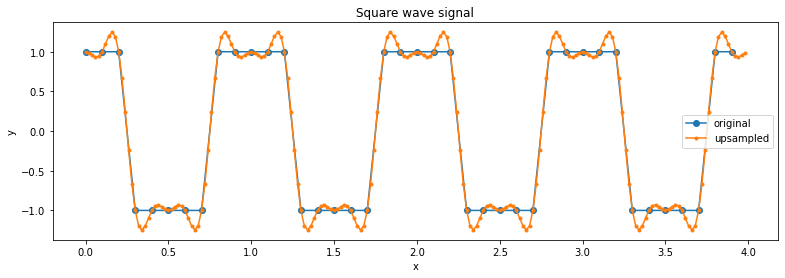

In [183]:
# 3) frequency to time domain
coef = a + 1j * b
coef[1:-1] = 0.5 * np.conj(coef[1:-1])

upsampled_x = np.linspace(0, L*scalar, n*scalar, endpoint=False) / scalar
upsampled_y = np.fft.irfft(coef, n*scalar, norm='forward')

plt.figure(figsize=(13, 4))
plt.plot(x, y, '-o', label='original')
plt.plot(upsampled_x, upsampled_y, '-o', markersize=3, label='upsampled')

plt.title('Square wave signal')
plt.ylabel('y')
plt.xlabel('x')

plt.legend(loc='right')

plt.show()

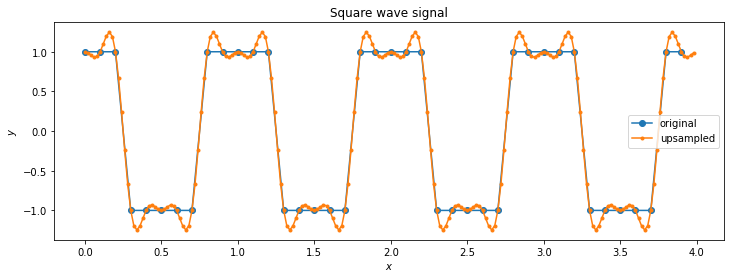

### Exercise 7

Complete the below skeleton function `fourier_resample()` that resamples a specified regularly sampled signal `yi` using Fourier interpolation. The user supplies the desired number of samples `n` in the signal as a required argument.

* If `n` is larger than the size of `yi`, pad the spectrum with zeros

* If `n` is smaller than the size of `yi`, crop the spectrum to a shorter extent.

<small>**Note:** write your own code that implements the described approach; the use of the `rfft()` and `irfft()` functions from `numpy.fft` or `scipy.fft` is permitted, but do *not* simply wrap the `resample()` function that `scipy` provides!</small>

```python
def fourier_resample(yi, n):
    """y = fourier_resample(yi, n).
    Fourier interpolation method that resamples a given
    signal yi to n new points. The first element of the
    returned signal y coincides with the first element
    of the provided signal yi.
    yi     = {y1,y2,...,xn}
    n      = desired number of points
    """
    pass   # ADD YOUR OWN CODE HERE
    return y
```

In [184]:
def fourier_resample(yi, n):
    """y = fourier_resample(yi, n).
    Fourier interpolation method that resamples a given
    signal yi to n new points. The first element of the
    returned signal y coincides with the first element
    of the provided signal yi.
    yi     = {y1,y2,...,xn}
    n      = desired number of points
    """
    
    yi = yi.astype('float64')
    
    # generate coef
    coef = np.fft.rfft(yi, norm='forward')
    if yi.size % 2 == 0:
        coef[1:-1] = 2.0 * np.conj(coef[1:-1])
    else:
        coef[1:] = 2.0 * np.conj(coef[1:])
        
    a, b = np.real(coef), np.imag(coef)
    spectrum = np.sqrt(a*a + b*b)
    
    # How to get ts???
    freq = np.fft.rfftfreq(y.size, ts)
    return y

### Exercise 8

Consider the following data regarding the average amount of precipitation in the city of Groningen across all months in a year (from: [Climates to travel](https://www.climatestotravel.com/climate/netherlands/groningen)).

| Month     | P [mm] |   | Month     | P [mm] |
| --------- | ------ | - | --------- | ------ |
| January   |   75   |   | July      |   85   |
| February  |   50   |   | August    |   80   |
| March     |   55   |   | September |   75   |
| April     |   45   |   | October   |   70   |
| May       |   60   |   | November  |   70   |
| June      |   65   |   | December  |   80   |

Plot these data together with versions that have been up- or downsampled using your `fourier_resample()` function to 6, 12, and 36 samples, respectively.

Does the resampled signal always reproduce the original data whenever the $x$-values coincide?

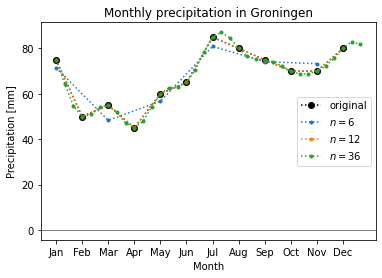

### Exercise 9

Upsample the temperature data by a factor of four using the *discrete cosine transform* instead of the *discrete Fourier transform*.

Compare the result to the example that employed the Fourier transform with these data, and explain any differences you observe.

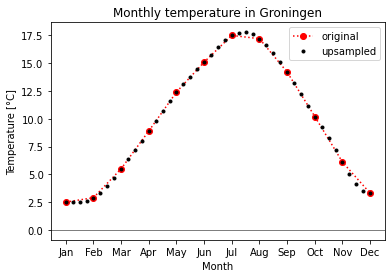

### <a id="/13">Lesson 5 - Applications of the Fourier transform</a>

* <span style="color:#336699"><a href="#/1">Part 5A</a><br />Fourier filtering</span>

* <span style="color:#336699"><a href="#/7">Part 5B</a><br />Fourier interpolation</span>

* <u>Part 5C</u><br />*Fourier smoothing*

* <span style="color:#336699"><a href="#/19">Part 5D</a><br />Short-term Fourier Transform</span>

Random measurement [noise](https://en.wikipedia.org/wiki/Noise_(signal_processing)) tends to contribute to all frequencies in a spectrum, although it can have different spectral characteristics depending on its [color](https://en.wikipedia.org/wiki/Colors_of_noise).

<img src="https://frodoclark1943.files.wordpress.com/2012/01/whitepinkbrownnoise.jpg" alt="White, brown and pink noise" width="25%" height="25%" />

Usually, signals of interest fluctuate fairly slowly, provided the sampling frequency is sufficiently high. Therefore, a promising approach to reduce measurement noise is to [smoothen](https://en.wikipedia.org/wiki/Smoothing) the signal by applying low-pass filtering.

The figure illustrates an artificial but complicated signal that includes some random white noise.

The spectrum shows strong amplitudes at low frequencies, resulting from the signal of interest. At all frequencies, there also is some noise contribution, which becomes dominant at higher frequencies.

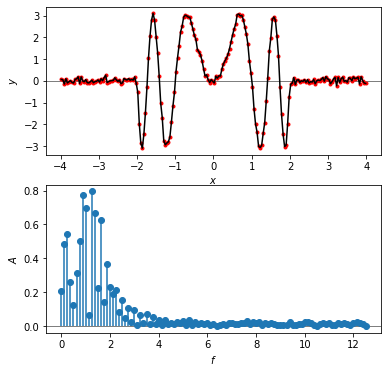

Figure 7: Signal & Spectrum


In [29]:
figure(7)

To remove the noise, we may apply a low-pass filter. In this example, the transfer function has a cutoff frequency $f_\text{max}=2$.

Upon transforming the spectrum back into the time domain, the obtained smoothed signal (in black) fits the measurements (in red) quite well.

However, for $t<-2$ and $t>2$, the filtered signal oscillates, whereas the original signal contained no fluctuations (except noise).

The frequency at which this ringing occurs equals $f=2$. This is related to the fact that the transfer function shows an abrupt change at $f=2$.

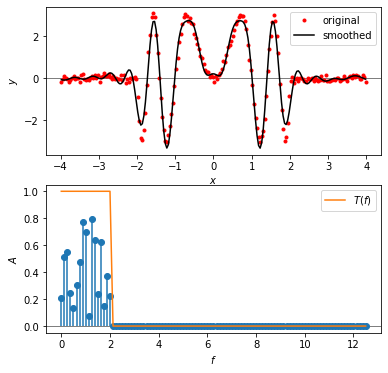

Figure 8: Signal & Spectrum


In [30]:
figure(8)

To avoid this, it is customary to employ a transfer function that varies smoothly.

Here, the transfer function shows a linear transition from $T(f)=1$ at low $f$ to $T(f)=0$ at high $f$.

As a result, the ringing artifact is much reduced, whereas the signal fit remains quite good.

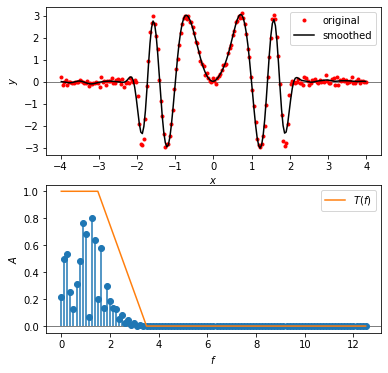

Figure 9: Signal & Spectrum


In [31]:
figure(9)

The transfer function can take on numerous [window shapes](https://en.wikipedia.org/wiki/Window_function).

* A [boxcar window](https://en.wikipedia.org/wiki/Boxcar_function) is constant

* A triangular window declines linearly towards the edges of the interval

* An exponential or Poisson window decays exponentially

* A gaussian window is shaped like a bell-curve

* A (half-)cosine window contains the positive lobe of a sinusoid

* A [Hanning](https://en.wikipedia.org/wiki/Hann_function) window contains a full period of a sinusoid

* A Tukey window is has sinusoidal transitions at its edges

* Etcetera.

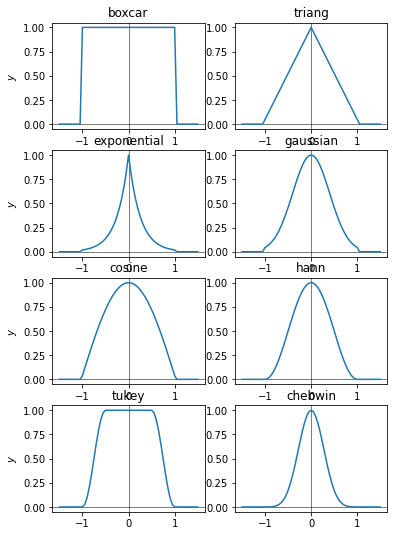

Figure 10: Symmetrical window shapes


In [32]:
figure(10)

The figure demonstrates the use of (half) a Tukey window, which tapers in the shape of a cosine.

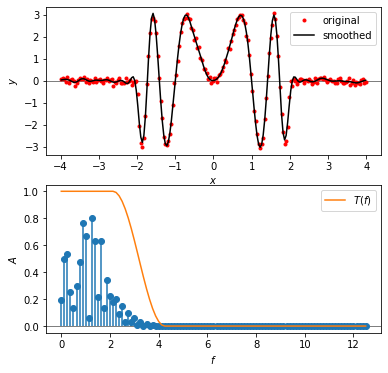

Figure 11: Signal & Spectrum


In [33]:
figure(11)

### Example

This example shows a 1<sup>st</sup>-order [Bessel function](https://en.wikipedia.org/wiki/Bessel_function) of the first kind $J_1(x)$ that is sampled from $x=-20$ to $x=20$ with some noise. The sampling frequency is 5, such that the Nyquist frequency equals $2\frac{1}{2}$.

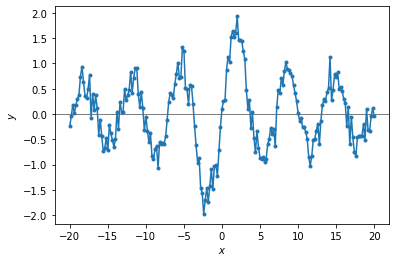

In [97]:
from scipy.special import jv
x = np.linspace(-20.0, 20.0, 201)
y = 3.0 * jv(1, x) + np.random.randn(201) * 0.2

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(x, y, '.-')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.show()

The amplitude spectrum includes a broad peak caused by the signal near $f=0.15$. Otherwise, the spectrum mostly consists of noise contributions.

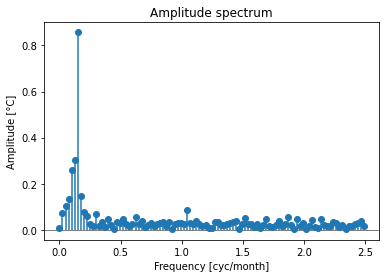

In [98]:
coef = np.fft.rfft(y, norm='forward')
coef[1:] = 2.0 * np.conj(coef[1:])
a, b = np.real(coef), np.imag(coef)
spectrum = np.sqrt(a * a + b * b)
f = np.fft.rfftfreq(y.size, 0.2)

plt.axhline(0.0, color='k', lw=0.5)
plt.stem(f, spectrum, basefmt='None')
plt.xlabel('Frequency [cyc/month]'); plt.ylabel('Amplitude [°C]')
plt.title('Amplitude spectrum')
plt.show()

Here, we manually define a transfer function that equals 1 for frequencies $f < f_\text{max} = 0.2$, and that exponentially decays for frequencies above that cutoff.

<small>**Note:** how to define such a transfer function is to some degree arbitrary; for this application, it should decay from 1 for low frequencies (including 0.15) to 0 at high frequencies, and preferably show a continuous transition in between, but the exact shape is not critical.</small>



Text(0.5, 0, 'sample')

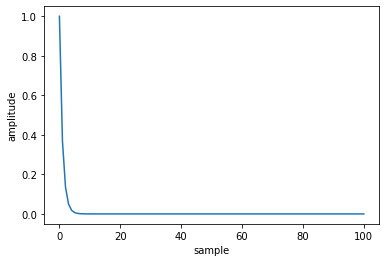

In [113]:
from scipy.signal.windows import exponential

M = f.size

window = exponential(M, center=0, sym=False)
plt.figure()
plt.plot(window)
plt.ylabel('amplitude')
plt.xlabel('sample')

In [92]:
def neg_to_1(x):
    if x < 0.0:
        return 1
    
    return x

test = window * (f-0.2)

test = np.array([neg_to_1(xi) for xi in test])

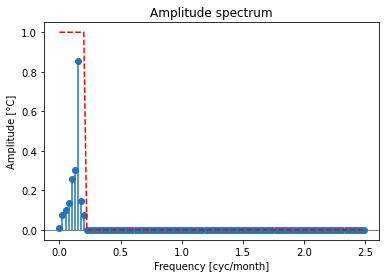

In [108]:
# transfer = np.minimum(np.exp(-10.0 * (f - 0.2)), 1.0)
transfer = test
a *= transfer
b *= transfer
spectrum = np.sqrt(a * a + b * b)

plt.axhline(0.0, color='k', lw=0.5)
plt.stem(f, spectrum, basefmt='None')
plt.plot(f, transfer, '--r')
plt.xlabel('Frequency [cyc/month]'); plt.ylabel('Amplitude [°C]')
plt.title('Amplitude spectrum')
plt.show()

Transforming the spectrum back into the time domain we obtain a wonderful fit to the original data.

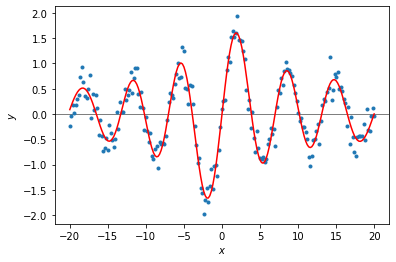

In [109]:
coef = a + 1j * b
coef[1:] = np.conj(coef[1:]) / 2.0
cleaned = np.fft.irfft(coef, 201, norm='forward')
                   
plt.axhline(0.0, color='k', lw=0.5)
plt.plot(x, y, '.')
plt.plot(x, cleaned, '-r')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.show()

### Other useful functions

The `scipy.signal.windows` module provides a [long list](https://docs.scipy.org/doc/scipy/reference/signal.windows.html) of windowing functions that may prove useful. These include the `boxcar()`, `triang()`, `exponential()`, `gaussian()`, `cosine()`, `hann()`, `tukey()`, and `chebwin()` window shapes that were illustrated previously (and several more). These all include an argument that indicates the size of the window, expressed as a number of elements in the array.

In [12]:
from scipy.signal.windows import triang
triang(10)

array([0.1, 0.3, 0.5, 0.7, 0.9, 0.9, 0.7, 0.5, 0.3, 0.1])

The listed `scipy` functions generate symmetric windows. To obtain a one-sided window, we can select the first or second half of a window with double the desired width.

In [39]:
triang(20)[10:]

array([0.95, 0.85, 0.75, 0.65, 0.55, 0.45, 0.35, 0.25, 0.15, 0.05])

### Exercise 10

Repeat exercise 1, but instead of a low-pass filter with a transfer function with a boxcar shape, try a smoothly declining gaussian function

$$
T(f) = e^{-\frac{f^2}{2\sigma^2}}
$$

Can you succeed in limiting the ringing artifact at the discontinuities in the original signal?

In [114]:
from scipy.signal.windows import gaussian

In [121]:
def square(t):
    return np.sign(np.sin(2*np.pi*f*(t + 0.25)))

L = 4
f = 1
fs = 50 # 1 / ts 
n = L * fs
ts = L / n

x = np.linspace(0, 4, 200, endpoint=False)
y = square(x)

200

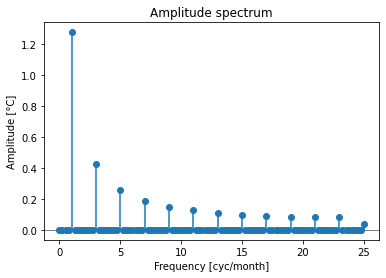

In [122]:
# convert to frequency domain
coef = np.fft.rfft(y, norm='forward')
coef[1:-1] = 2.0 * np.conj(coef[1:-1])
a, b = np.real(coef), np.imag(coef)
spectrum = np.sqrt(a * a + b * b)
f = np.fft.rfftfreq(y.size, ts)

plt.axhline(0.0, color='k', lw=0.5)
plt.stem(f, spectrum, basefmt='None')
plt.xlabel('Frequency [cyc/month]'); plt.ylabel('Amplitude [°C]')
plt.title('Amplitude spectrum')
plt.show()

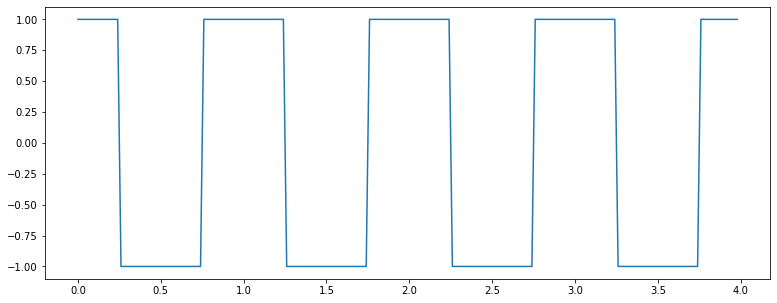

In [120]:
plt.figure(figsize=(13, 5))
plt.plot(x, y)

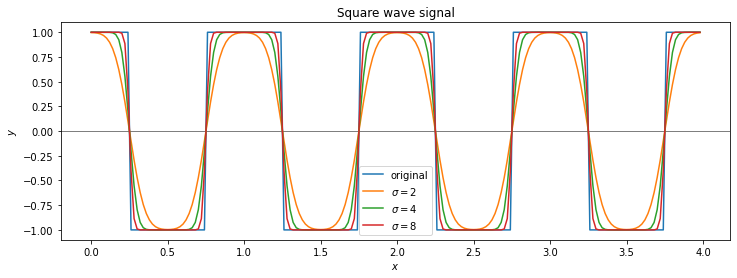

### Exercise 11

Define your own function `fourier_smooth()` that, for a given regularly sampled signal $\boldsymbol{y}$ with sampling time `d`, applies a low-pass filter that blocks all frequencies above a cutoff `fmax`, and applies a supplied window shape to the lower frequencies, passing through the zero frequency unaffected.

<small>**Note:** the function `scipy.signal.get_window()` may prove useful; a small number of window functions require additional arguments in addition to the window size, but you may ignore these.</small>

```python
def fourier_smooth(yi, d, fmax, shape='boxcar'):
    """y = fourier_smooth(yi, d, fmax, shape='boxcar').
    Smoothing function that low-pass filters a signal
    yi with sampling time d. Spectral components with
    frequencies above a cut-off fmax are blocked, while
    lower frequencies are multiplied with a transfer
    function with a given shape.
    yi     = {y1,y2,...,xn}
    d      = sampling time
    fmax   = low-pass cut-off frequency
    shape  = transfer function shape (default 'boxcar')
    """
    pass   # ADD YOUR OWN CODE HERE
    return y
```

### Exercise 12

The following code snippet extracts data regarding the change in global surface temperature relative to 1951-1980 average temperatures (from: [NASA](https://climate.nasa.gov/vital-signs/global-temperature/)) into a `pandas` dataframe named `climate`.

```python
url = 'https://data.giss.nasa.gov/gistemp/graphs/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.txt'
climate = pd.read_csv(url, delim_whitespace=True, skiprows=5,
                      usecols=[0, 1], index_col=0, names=['Year', 'Anomaly [°C]'])
```

Plot the global temperature together with a smooth trendline obtained with your `fourier_smooth()` function using a triangular window. Choose the cut-off frequency $f_\text{max}$ appropriately such that you get a curve that follows the robust trends in the data, but not the stochastic variations.

There is an obvious shortcoming in this curve; explain why that occurs, and propose a way to overcome this.

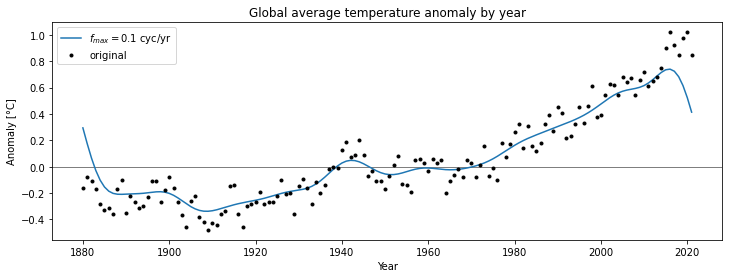

### Exercise 13

The following code loads the daily percentage sunshine that was measured across the last four years in Eelde (Groningen, NL).

```python
url = 'https://daggegevens.knmi.nl/klimatologie/daggegevens?' + \
      'start=20180101&end=20211231&stns[280]=1&vars[SP]=1'
sun = pd.read_csv(url, comment='#', usecols=[1, 2], names=['Day', 'Sunshine [%]'])
```

Smooth the signal using a low-pass filter with transfer function window shapes of the form `'boxcar'`, `'cosine'`, `'hann'`, and `'parzen'` and a cut-off frequency $f_\text{max} = 6$ cyc/yr.

Which window shape performs worst, in your opinion; can you explain why?

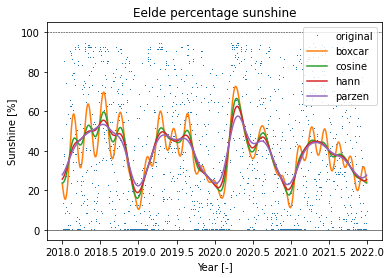

### <a id="/19">Lesson 5 - Applications of the Fourier transform</a>

* <span style="color:#336699"><a href="#/1">Part 5A</a><br />Fourier filtering</span>

* <span style="color:#336699"><a href="#/7">Part 5B</a><br />Fourier interpolation</span>

* <span style="color:#336699"><a href="#/13">Part 5C</a><br />Fourier smoothing</span>

* <u>Part 5D</u><br />*Short-term Fourier Transform*

### Uncertainty principle

We define a signal with a narrow frequency content and a moderate temporal extent by multiplying a pure sinusoidal [carrier wave](https://en.wikipedia.org/wiki/Carrier_wave) (with $f=1$) by a gaussian windowing function (with $\sigma=1$):

$$
y(x) = c(x) \cdot w(x) = \cos \left( 2\pi f x \right) \cdot e^{-\frac{x^2}{2\sigma^2}}
$$

The result is a (Morlet) [wavelet](https://en.wikipedia.org/wiki/Wavelet) shape.

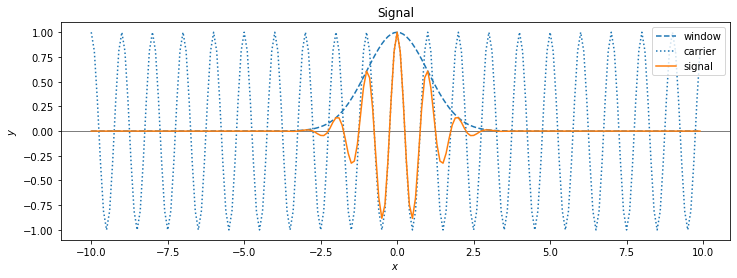

Figure 12: Signal


In [44]:
figure(12)

Upon Fourier transformation of this signal, the obtained spectrum is dominated by a peak at $f=1$, but also shows substantial amplitudes at other frequencies near $f=1$.

<small>**Note:** because the signal was generated with a sampling time $t_s=0.1$, the spectrum runs until $f_\text{Ny}=5$.</small>

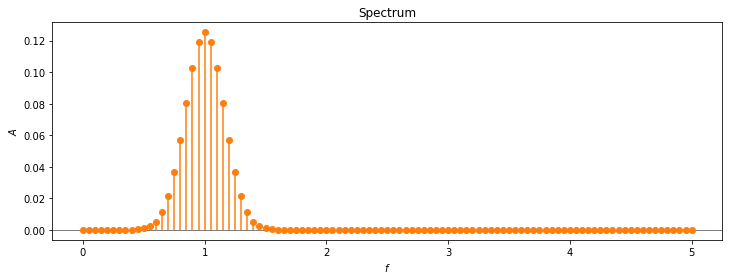

Figure 13: Spectrum


In [45]:
figure(13)

When the carrier frequency is varied, but the windowing function is kept the same, the center frequency of the peak in the spectrum shifts, but its width remains the same.

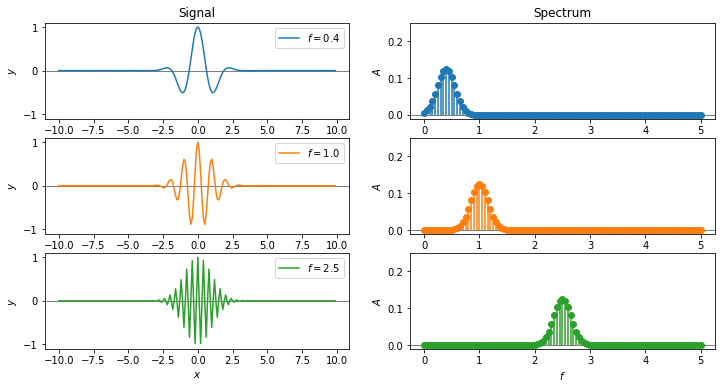

Figure 14: Signals & Spectra


In [46]:
figure(14)

When the window width is varied, but the carrier frequency is kept the same, the width of the peak in the spectrum changes, but the center frequency remains the same.

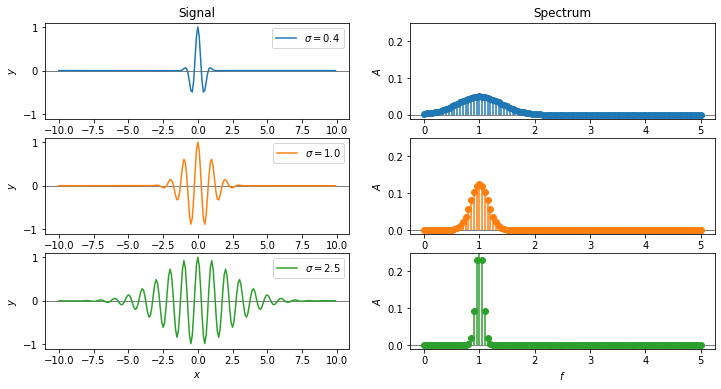

Figure 15: Signals & Spectra


In [47]:
figure(15)

In summary

* a *narrow* signal corresponds with a *broad* spectrum

* a *broad* signal corresponds with a *narrow* spectrum

This further underlines the duality between the time and frequency domains.

As a result, the oscillations in a signal cannot be simultaneously well localized in time as well as in frequency. This is known as the [uncertainty principle](https://en.wikipedia.org/wiki/Uncertainty_principle).

<small>**Note:** this closely relates to the uncertainty principle in Quantum Mechanics, according to which it is impossible to simultaneously know the position and speed of a particle.</small>

For the most extreme cases

* a maximally *narrow* window localizes a sinusoidal signal with *optimal* accuracy in the time domain because it spans a *single* sample, but localizes the spectrum with *zero* accuracy in the frequency domain because it spans *all* components

* a maximally *wide* window localizes a sinusoidal signal with *zero* accuracy in the time domain because it spans *all* samples, but localizes the spectrum with *optimal* accuracy in the frequency domain because it spans a *single* component

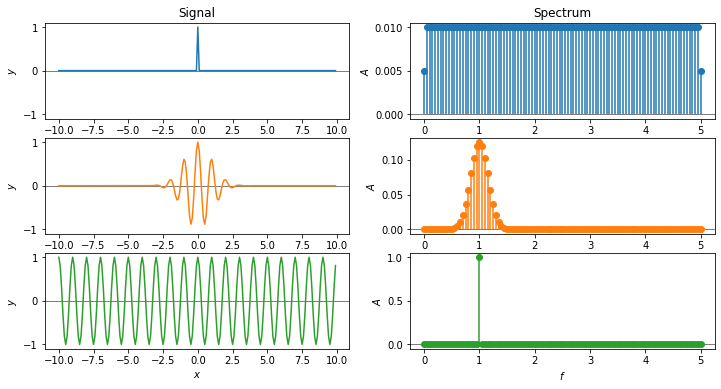

Figure 16: Signals & Spectra


In [48]:
figure(16)

### Short-term Fourier transform

Below, a [chirp](https://en.wikipedia.org/wiki/Chirp) is defined that increases in frequency over time. In this particular example, the signal's instantaneous frequency rises linearly from $f=0$ at $t=0$ to $f=5$ at $t=10$.

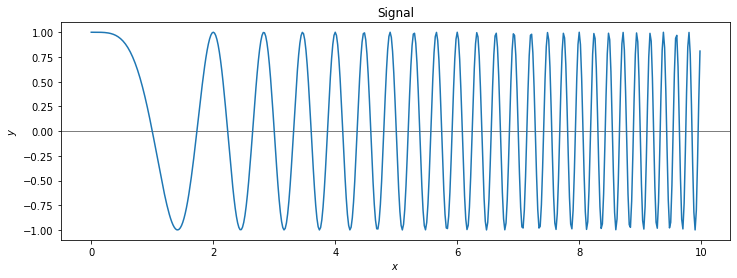

Figure 17: Signal


In [49]:
figure(17)

Overall, the amplitude spectrum shows strong amplitudes in the region $0 < f < 5$, which is consistent with the signal sweeping through those frequencies. However, this provides no information at all about which frequencies occur at what moment in time.

<small>**Note:** because the signal was generated with a sampling time $t_s=0.02$, the spectrum runs until $f_\text{Ny}=25$, but the below plot has been cropped.</small>

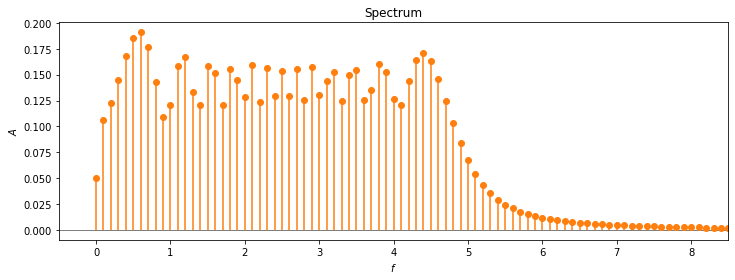

Figure 18: Spectrum


In [50]:
figure(18)

We can exchange localization accuracy in the time domain against localization accuracy in the frequency domain by applying a window. Below, a Hanning window is applied at several moments in time.

<small>**Note:** because the window of width 2 is shorter than the original signal, the spacing between frequency components increases to $\Delta f = \frac{1}{2}$.</small>

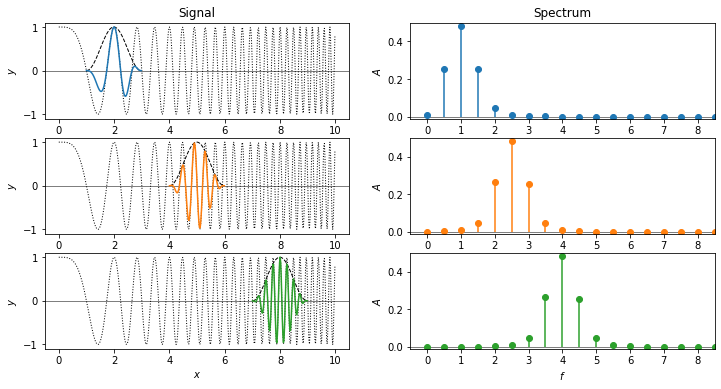

Figure 19: Signal & Spectrum


In [51]:
figure(19)

By sweeping the window across the signal and collecting the spectra into a 2-D array, a [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) can be plotted as a function of both time and frequency. This procedure is known as the [short-term Fourier transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) (STFT). The spectrogram graphically displays the dynamic frequency content of the signal.

In the below spectrogram, we step along the time axis in increments of $\Delta x = \frac{1}{5}$.

<small>**Note:** the time axis is cropped because the center of the window does not extend beyond the bounds of the signal; alternatively, the signal could have been padded with zeros, or the window could have been wrapped around.</small>

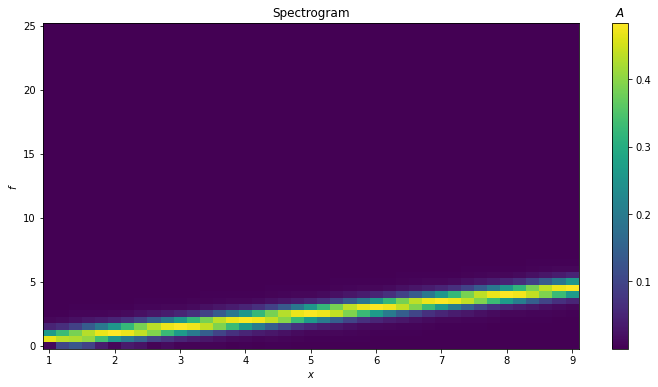

Figure 20: Spectrogram


In [52]:
figure(20)

### Example

The signal that is shown here contains two overlapping sinusoids

* a wave with frequency $f=2$ from $t=1$ to $5$

* a wave with frequency $f=5$ from $t=3$ to $7$

In addition, the signal contains some random noise.

We wish to determine the signal's spectrogram to distinguish the two sinusoids.

<small>**Note:** $L = 8$ and $t_s = \frac{1}{40}$.</small>

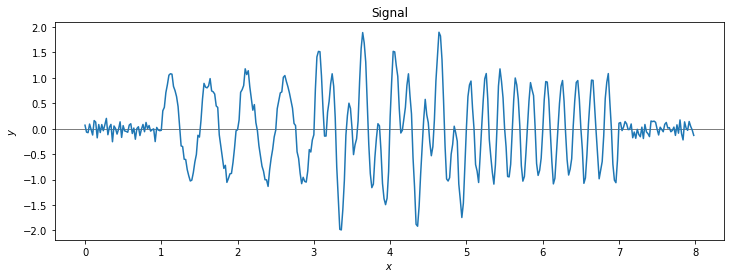

In [53]:
x = np.linspace(0.0, 8.0, 400, endpoint=False)
y = np.random.randn(x.size) * 0.1
y[ 50:250] += np.sin(2.0 * np.pi * 2.0 * x[ 50:250])
y[150:350] += np.sin(2.0 * np.pi * 5.0 * x[150:350])

plt.figure(figsize=(12.0, 4.0))
plt.axhline(0.0, color='k', lw=0.5)
plt.plot(x, y, '-')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.title('Signal')
plt.show()

First, we consider the spectrum of the entire signal.

Two clear peaks occur, one at $f=2$ and one at $f=5$, on top of a noisy baseline.

The peaks are slightly broadened because the width of the sinusoids in time is limited to only a portion of the signal.

<small>**Note:** $f_\text{Ny} = 25$ and $\Delta f = \frac{1}{8}$.</small>

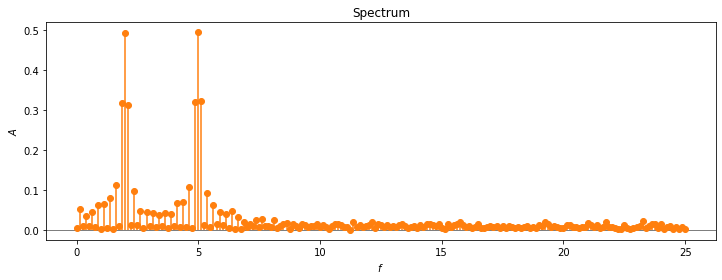

In [54]:
def spectrum(signal, d):
    assert signal.size % 2 == 0   # Assume even n
    coef = np.fft.rfft(signal, norm='forward')
    coef[1:-1] = 2.0 * np.conj(coef[1:-1])
    a, b = np.real(coef), np.imag(coef)
    f = np.fft.rfftfreq(signal.size, d)
    A = np.sqrt(a * a + b * b)
    return f, A

f, A = spectrum(y, 0.02)

plt.figure(figsize=(12.0, 4.0))
plt.axhline(0.0, color='k', lw=0.5)
plt.stem(f, A, linefmt='-C1', markerfmt='oC1', basefmt='None')
plt.xlabel('$f$'); plt.ylabel('$A$')
plt.title('Spectrum')
plt.show()

Next, we zoom in on a single window in time. In this example, the window is centered on $x=3$ with a width of 1.

No tapering was applied, thus the window corresponds with a boxcar function.

The amplitude spectrum contains

* a sharp peak at $f=2$ because this sinusoid is present in the entire window, and cycles through an integer number of periods

* a broad peak at $f=5$ because that sinusoid is present in only the second half of the window

<small>**Note:** $t_s = \frac{1}{40}$ and $f_\text{Ny} = 25$ remain the same, whereas now $L = 1$ and $\Delta f = 1$.</small>

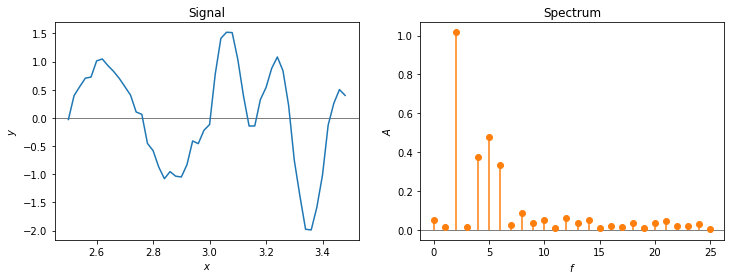

In [55]:
center = 150   # in samples
width = 50     # in samples
x2 = np.roll(x, width // 2 - center)[:width]
y2 = np.roll(y, width // 2 - center)[:width]
f2, A2 = spectrum(y2, 0.02)

plt.figure(figsize=(12.0, 4.0))
plt.subplot(1, 2, 1)
plt.axhline(0.0, color='k', lw=0.5)
plt.plot(x2, y2, '-')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.title('Signal')
plt.subplot(1, 2, 2)
plt.axhline(0.0, color='k', lw=0.5)
plt.stem(f2, A2, linefmt='-C1', markerfmt='oC1', basefmt='None')
plt.xlabel('$f$'); plt.ylabel('$A$')
plt.title('Spectrum')
plt.show()

Finally, the boxcar window is swept across the signal in steps of 10 samples, i.e. $\Delta x = \frac{1}{5}$. Spectra are collected in the spectrogram.

The two sinusoids can clearly be distinguished from each other along the frequency axis, but also their start and stop can be seen to differ in time.

<small>**Note:** in the code, the signal is cyclically *rolled* through the window, rather than sweeping the window across the signal, but the effect is the same.</small>

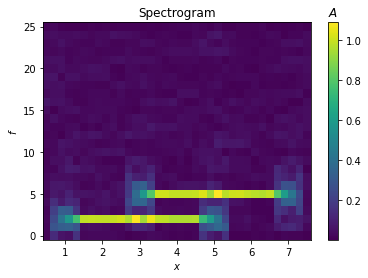

In [56]:
centers = np.arange(0, 401 - width, 10) + width // 2
xs = centers * 0.02
fs = np.fft.rfftfreq(width, 0.02)
stft = np.empty((fs.size, xs.size))
for col, center in enumerate(centers):
    x2, y2 = np.roll(x, width // 2 - center)[:width], np.roll(y, width // 2 - center)[:width]
    _, stft[:, col] = spectrum(y2, 0.02)
    
plt.pcolormesh(xs, fs, stft, shading='nearest')
plt.xlabel('$x$'); plt.ylabel('$f$')
plt.title('Spectrogram')
cbar = plt.colorbar(); cbar.ax.set_title('$A$')
plt.show()

Interestingly, we can now exchange temporal resolution against spectral resolution: on the right, the window width is made *narrower*, effectively resulting in *better* time resolution, but *worse* spectral resolution; on the left, the window width is made *broader*, effectively resulting in *worse* time resolution, but *better* spectral resolution.

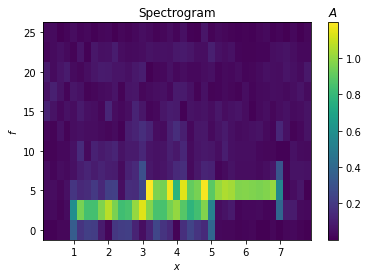

In [57]:
width = 20
centers = np.arange(0, 401 - width, 10) + width // 2
xs = centers * 0.02
fs = np.fft.rfftfreq(width, 0.02)
stft = np.empty((fs.size, xs.size))
for col, center in enumerate(centers):
    x2, y2 = np.roll(x, width // 2 - center)[:width], np.roll(y, width // 2 - center)[:width]
    _, stft[:, col] = spectrum(y2, 0.02)
    
plt.pcolormesh(xs, fs, stft, shading='nearest')
plt.xlabel('$x$'); plt.ylabel('$f$')
plt.title('Spectrogram')
cbar = plt.colorbar(); cbar.ax.set_title('$A$')
plt.show()

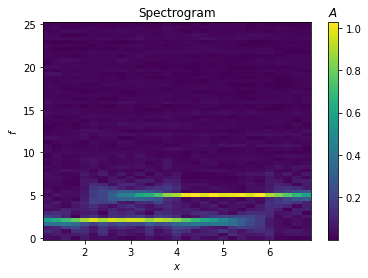

In [58]:
width = 120
centers = np.arange(0, 401 - width, 10) + width // 2
xs = centers * 0.02
fs = np.fft.rfftfreq(width, 0.02)
stft = np.empty((fs.size, xs.size))
for col, center in enumerate(centers):
    x2, y2 = np.roll(x, width // 2 - center)[:width], np.roll(y, width // 2 - center)[:width]
    _, stft[:, col] = spectrum(y2, 0.02)
    
plt.pcolormesh(xs, fs, stft, shading='nearest')
plt.xlabel('$x$'); plt.ylabel('$f$')
plt.title('Spectrogram')
cbar = plt.colorbar(); cbar.ax.set_title('$A$')
plt.show()

### Other useful functions

The `scipy.signal` module contains a function `spectrogram()` that applies the short-term Fourier transform to produce a spectrogram.

In [59]:
from scipy.signal import spectrogram
help(spectrogram)

Help on function spectrogram in module scipy.signal.spectral:

spectrogram(x, fs=1.0, window=('tukey', 0.25), nperseg=None, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1, mode='psd')
    Compute a spectrogram with consecutive Fourier transforms.
    
    Spectrograms can be used as a way of visualizing the change of a
    nonstationary signal's frequency content over time.
    
    Parameters
    ----------
    x : array_like
        Time series of measurement values
    fs : float, optional
        Sampling frequency of the `x` time series. Defaults to 1.0.
    window : str or tuple or array_like, optional
        Desired window to use. If `window` is a string or tuple, it is
        passed to `get_window` to generate the window values, which are
        DFT-even by default. See `get_window` for a list of windows and
        required parameters. If `window` is array_like it will be used
        directly as the window and its length must

The following arguments of the `spectrogram()` function are particularly useful:

* the first argument contains the regularly sampled signal array

* a floating-point argument `fs` denotes the sampling frequency

* an integer argument `nperseg` indicates the width of the window, expressed as a number of samples

* an integer argument `noverlap` controls the spacing of windows in time through number of samples that adjacent windows overlap (i.e., $\Delta x = (n_\text{nperseg}-n_\text{noverlap}) \cdot t_s$)

In addition

* a parameter `window` allows the sweeping window to be tapered with a specified shape to reduce artifacts in the spectrum

The previous example corresponds with `window='boxcar'`. Three other parameters should be set equal to `detrend=False`, `scaling='spectrum'`, and `mode='magnitude'` for the result to match our approach.

The `spectrogram` function returns three arrays:

* a 1-D array with frequency values, corresponding with the rows of the spectrogram

* a 1-D array with $x$ values indicating the center of the window, corresponding with the columns of the spectrogram

* a 2-D array containing the amplitudes of the spectrogram

Like for the `rfft()` and `dct()` functions, the reported amplitudes should be corrected by a factor of 2 for all frequencies except the zero frequency and the Nyquist frequency.

<small>**Note:** the spectrogram is real-valued, so no conjugation is required.</small>

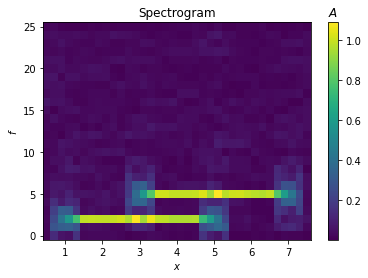

In [60]:
fs, xs, stft = spectrogram(
    y,
    fs=50.0,
    nperseg=50,
    noverlap=40,
    window='boxcar',
    detrend=False,
    scaling='spectrum',
    mode='magnitude'
)
stft[1:-1, :] *= 2.0

plt.pcolormesh(xs, fs, stft, shading='nearest')
plt.xlabel('$x$'); plt.ylabel('$f$')
plt.title('Spectrogram')
cbar = plt.colorbar(); cbar.ax.set_title('$A$')
plt.show()

### Exercise 14

The following snippet samples a wave function $y(x)$ that is simultaneously [amplitude-modulated](https://en.wikipedia.org/wiki/Amplitude_modulation) (AM) between $A=1$ and $A=3$ and [frequency-modulated](https://en.wikipedia.org/wiki/Frequency_modulation) (FM) between $f=10$ and $f=50$.

```python
x = np.linspace(0.0, 2.0, 1000, endpoint=False)
totalphase = 2.0 * np.pi * np.cumsum(30.0 - 20.0 * np.cos(3.0 * np.pi * x)) * 2.0e-3
amplitude = 2.0 + np.sin(3.0 * np.pi * x)
y = amplitude * np.sin(totalphase)
```

Plot the signal, its spectrum, and its spectrogram.

Choose the settings for the short-term Fourier transform such that the spectrogram looks most informative.

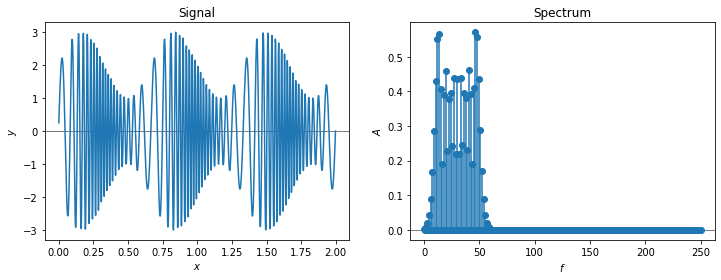

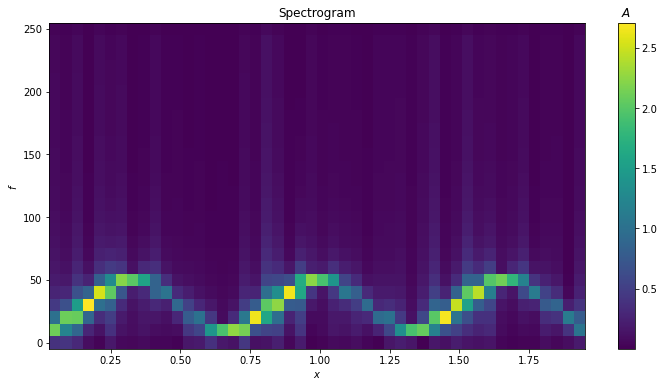

### Exercise 15

Define your own function `stft_transform()` that, for a given regularly sampled signal $\boldsymbol{y}$, determines the spectrogram according to the short-term Fourier transform. The user should specify the employed sampling time, and the desired resolutions $\Delta x$ and $\Delta f$ of the spectrogram in the time and frequency domains (as floats in units of time and frequency), respectively. The function should return the amplitude spectrogram as a 2-D array, as well as the $f$ and $x$ corresponding with the rows and columns, respectively.

<small>**Note:** Write your own code that implements the described method; do *not* simply wrap the `spectrogram()` function from `scipy.signal`!</small>

```python
def stft_transform(yi, d, deltaf, deltax):
    """f, x, stft = stft_transform(yi, d, deltaf, deltax).
    Short-term Fourier transform that determines the
    spectrogram of a signal yi. The sampling time d as well
    as the desired resolution deltaf in the frequency domain
    and deltat in the time domain should be provided.
    yi     = {y1,y2,...,xn}
    d      = sampling time
    deltaf = spectral resolution
    deltax = temporal resolution
    """
    pass   # ADD YOUR OWN CODE HERE
    return f, x, stft
```

### Exercise 16

The following code fragment loads the approximately 12-second long waveform of a sound recording that contains the song of a humpback whale (from: [Ocean Mammal Institute](http://www.oceanmammalinst.org/songs.html)).

```python
import io, requests, wave
url = 'http://www.oceanmammalinst.org/songs/hmpback3.wav'
sound = wave.open(io.BytesIO(requests.get(url).content))
rate = sound.getframerate()
data = np.frombuffer(sound.readframes(sound.getnframes()), dtype=np.uint8).astype(float)
data = (data - np.mean(data)) / np.std(data)
display.Audio(data=data, rate=rate)
```

The variable `rate` contains the sampling frequency (in Hz); the waveform is contained in the variable `data`.

Plot the spectrogram of this sound wave using appropriate settings. Use a logarithmic transformation to express the amplitudes on a [decibel](https://en.wikipedia.org/wiki/Decibel) scale:

$$
A_\text{dB}=20\cdot \log_{10}(A)
$$

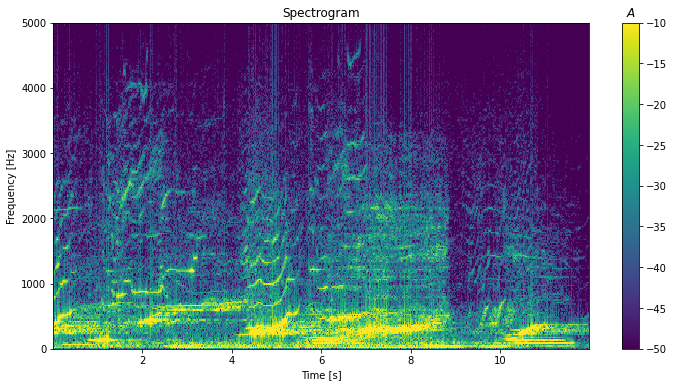

### Exercise 17

The code below downloads an approximately 1-minute long [phonocardiogram](https://en.wikipedia.org/wiki/Phonocardiogram) that contains the recording of a fetal heart sound that was obtained using a digital stethoscope placed on the lower maternal abdomen (form: [Shiraz University Fetal Heart Sounds Database](https://doi.org/10.13026/42eg-8e59)).

```python
import io, requests, wave
url = 'https://physionet.org/files/sufhsdb/1.0.1/f2.wav'
sound = wave.open(io.BytesIO(requests.get(url).content))
rate = sound.getframerate()
data = np.frombuffer(sound.readframes(sound.getnframes()), dtype=np.int16)[::2].astype(float)
data = (data - np.mean(data)) / np.std(data)
display.Audio(data=data, rate=rate)
```

The variable `rate` contains the sampling frequency (in Hz); the waveform is contained in the variable `data`.

Plot the spectrogram of this sound wave using settings that allow you to clearly distinguish the rhythm of the heart beat from the various background noises. Visually estimate the frequency(/frequencies) $f$ at which the heart beat is clearest, and extract a measure of the corresponding amplitude $A_f(t)$ as a function of time. From the spectrum of that signal determine the mean heart rate of this foetus (i.e. the number of beats per minute).

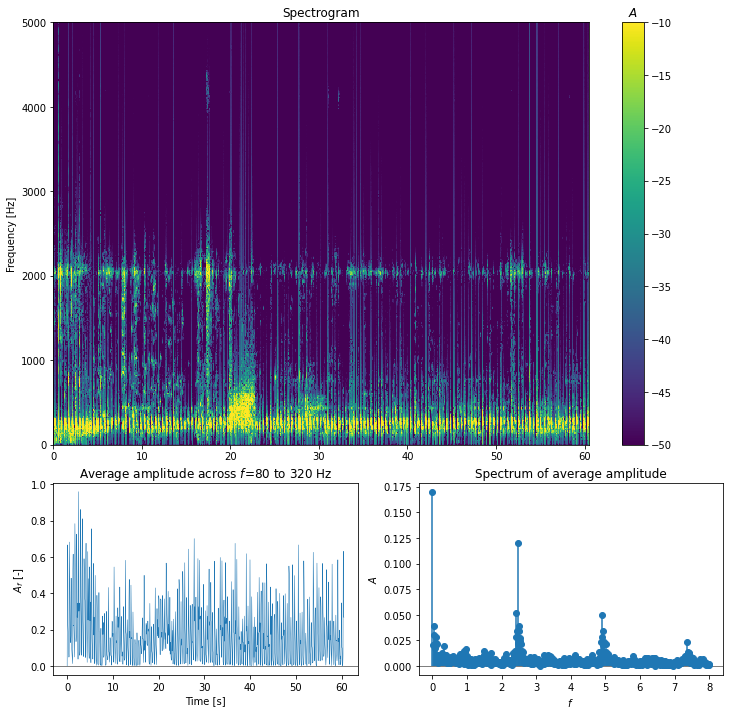

f_max (>0) = 2.463 Hz = 147.8 cyc/min


### End of lesson 5

Congratulations for finishing this lesson!

* Run your full notebook from scratch to ensure it works correctly (i.e., `Kernel` > `Restart & Run All`).

* Save your working version (i.e., `File` > `Save and Checkpoint`).

* Submit your completed notebook on [BlackBoard](https://blackboard.hanze.nl).

If handed in on time, you will be provided with feedback on your implementation of the `stft_transform()` function in **Part 5D**.

***